In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-ae5f7b1e-81ad-4d86-d684-faeffac13b15)


In [2]:
!nvidia-smi --query-gpu=memory.total --format=csv

memory.total [MiB]
16280 MiB


In [3]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score


In [4]:
import torch
print(f"Torch: {torch.__version__}")

Torch: 1.13.0


In [5]:
from __future__ import print_function

from itertools import chain
import os
import random
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import *
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import albumentations

In [6]:
train_path = ''
test_data  = pd.read_csv('/kaggle/input/balanced-csv/imbalance_test_data.csv')
main_df = pd.read_csv('/kaggle/input/balanced-csv/kaggle_balanced.csv')

main_df.columns = ['img_id','Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','Q_No finding']
main_df = main_df.reset_index()
main_df = main_df.drop(['index'],axis = 1)
main_df.head()

test_data.columns = ['img_id','Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','Q_No finding']
test_data = test_data.reset_index()
test_data = test_data.drop(['index'],axis = 1)

In [7]:
diseases = ['Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','Q_No finding']

In [8]:
all_frame = main_df
#all_frame['img_id'] = train_path+all_frame['img_id'] 
all_frame.head()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/vinbigdata-512-image-dataset/vin...,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(all_frame, test_size=0.20, random_state=42)

In [10]:
X_train.columns = ['img_id','Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','Q_No finding']
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis = 1)
#X_train['img_id'] = train_path+X_train['img_id'] 
X_train.head()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/nih-train/train_data/00006496_00...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,/kaggle/input/nih-train/train_data/00010007_02...,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
2,/kaggle/input/nih-train/train_data/00022132_00...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,/kaggle/input/nih-train/train_data/00025754_01...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,/kaggle/input/chex-data/chexpert/CheXpert-v1.0...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [11]:
X_val.columns = ['img_id','Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','Q_No finding']
X_val = X_val.reset_index()
X_val = X_val.drop(['index'],axis = 1)
#X_val['img_id'] = train_path+X_val['img_id'] 
X_val.head()
#X_test.sum()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/nih-train/train_data/00015799_00...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,/kaggle/input/nih-train/train_data/00003989_00...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/nih-train/train_data/00009349_04...,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0
3,/kaggle/input/pad-data/padchest_images/2168401...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
#test_data['img_id'] = train_path+test_data['img_id'] 
test_data.head()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,730ee58d327ab8bcdf8167683c71f565.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,d8284119d2a86d1f3db93bb6c32272fc.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5c9c0490f1629ab3659c7785ae22224d.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7db70125d7739e6cd0c442e7b7592d4c.png,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0
4,77694248815e59abca6fa327b40f4343.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
y_train = X_train.iloc[:,1:16]
y_val = X_val.iloc[:,1:16]
infer_test = test_data.iloc[:,1:16]
yseg_test = np.array(infer_test)
np.shape(y_train),np.shape(y_val),np.shape(infer_test)

((32904, 15), (8226, 15), (3000, 15))

In [14]:
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis = 1)

X_train['img_id'] = train_path+X_train['img_id'] 
X_train

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/nih-train/train_data/00006496_00...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,/kaggle/input/nih-train/train_data/00010007_02...,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
2,/kaggle/input/nih-train/train_data/00022132_00...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,/kaggle/input/nih-train/train_data/00025754_01...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,/kaggle/input/chex-data/chexpert/CheXpert-v1.0...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32899,/kaggle/input/vinbigdata-512-image-dataset/vin...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
32900,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32901,/kaggle/input/monai-data/new_dis_vinbig/Calcif...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
32902,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
X_val = X_val.reset_index()
X_val = X_val.drop(['index'],axis = 1)

X_val['img_id'] =train_path + X_val['img_id'] 
X_val.head()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/nih-train/train_data/00015799_00...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,/kaggle/input/nih-train/train_data/00003989_00...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/nih-train/train_data/00009349_04...,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0
3,/kaggle/input/pad-data/padchest_images/2168401...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
test_data = test_data.reset_index()
test_data = test_data.drop(['index'],axis = 1)

test_data['img_id'] ='/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/' + test_data['img_id'] 
test_data.head()

,img_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule_Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Q_No finding
0,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,/kaggle/input/vinbigdata-512-image-dataset/vin...,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0
4,/kaggle/input/vinbigdata-512-image-dataset/vin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
class CFG:
    strategy = tf.distribute.get_strategy()
    batch_size = 15
    
    
    img_size = 224 # image size
    folds = 5 # number of KFold n_splits
    seed = 42 # random seed (only for KFold)
    subfolds = 16 # number of .tfrec files in each fold
    transform = True # whether to apply pre-augmentations or not
    epochs = 4
    lr = 3e-5
    gamma = 0.7

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)

In [19]:
device = 'cuda'

In [20]:
img_size = 224
train_transforms = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop(img_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]
)

In [21]:
class Plant_Patho21(Dataset):
    def __init__(self,dataset, file_list, transform=None):
        self.dataset=dataset
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
#         print(self.dataset.head())
        label = np.array(self.dataset.iloc[:,1:])[idx]

        return img_transformed, label

In [22]:
all_data = Plant_Patho21(all_frame,list(all_frame['img_id']), transform=train_transforms)
train_data = Plant_Patho21(X_train,list(X_train['img_id']), transform=train_transforms)
valid_data = Plant_Patho21(X_val,list(X_val['img_id']), transform=test_transforms)
test_data_1 = Plant_Patho21(test_data,list(test_data['img_id']), transform=test_transforms)

In [23]:
#train_loader = DataLoader(dataset = train_data, batch_size=CFG.batch_size, shuffle=True )
#valid_loader = DataLoader(dataset = valid_data, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data_1, batch_size=CFG.batch_size, shuffle=False)

In [24]:
import torchvision
import torchvision.models as models
from torchvision.models import resnet50, vgg19, ResNet50_Weights

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def resnest_model(num_classes, feature_extract = False):
    model_ft = resnet50(pretrained = True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft.to(device)

def vgg_model(num_classes, feature_extract = False):
    model_ft = vgg19(pretrained = True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    return model_ft.to(device)

In [25]:
import os
import shutil
shutil.copytree('/kaggle/input/ga-only-mod-cvit', '/kaggle/working/mod_dvit2/')

'/kaggle/working/mod_dvit2/'

In [26]:
cd /kaggle/working/mod_dvit2

/kaggle/working/mod_dvit2


In [27]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00


In [28]:
#!pip install huggingface_hub

In [29]:
import timm 
model = timm.create_model('vit_large_patch32_384', pretrained=True, num_classes=15, img_size=img_size).to(device)

torch.Size([1, 1, 1024]) torch.Size([1, 49, 1024])


In [30]:
#from 30 epochs
model = torch.load('/kaggle/input/swa-or-ga-only-weight/cavit_ga_bal_kfold_4.pt')

In [31]:
from timm.loss import AsymmetricLossMultiLabel, AsymmetricLossSingleLabel

In [32]:
criterion = AsymmetricLossMultiLabel()

optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)


In [33]:
def label_update(output1):
    for i in range(len(torch.Tensor.cpu(output1).detach().numpy())):
        for k in range(len(output1[i])):
            if(output1[i][k]>=0.5):
                output1[i][k] = 1
            else:
                output1[i][k] = 0
    return output1

def test_update(out1):
    for i in range(len(torch.Tensor.cpu(out1).detach().numpy())):
        for k in range(len(out1[i])):
            if(out1[i][k]>0.5):
                out1[i][k] = 1
            else:
                out1[i][k] = 0
    return out1

In [34]:
import gc
gc.collect()

132

In [35]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [36]:
import gc

In [37]:
kfold = MultilabelStratifiedKFold(n_splits=5)
fold_indices = list(kfold.split(X = np.array(all_frame['img_id']),y = np.array(all_frame.iloc[:, 1:])))


for fold_idx, (train_indices, val_indices) in enumerate(fold_indices):

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(all_data, batch_size=CFG.batch_size, sampler=train_sampler)
    valid_loader = DataLoader(all_data, batch_size=CFG.batch_size, sampler=val_sampler)
        
    for epoch in range(CFG.epochs):
        epoch_accuracy = 0
        epoch_loss = 0
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for i, (data, label) in enumerate(tqdm(train_loader)):

            data = data.to(device)
            label = label.to(device)
            output = model(data)

            loss = criterion(output, torch.Tensor.float(label))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #epoch_loss += (loss.cpu().detach().numpy())/len(train_loader)

            #output_l = label_update(torch.sigmoid(output))
            #acc = (output_l == label).float().mean()
            #epoch_accuracy += acc
            
        #epoch_loss = epoch_loss/len(train_loader)    
        #epoch_accuracy = epoch_accuracy / len(train_loader)
        #gc.collect()

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for i, (data, label) in enumerate(tqdm(valid_loader)):
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, torch.Tensor.float(label))
                #epoch_val_loss += (val_loss.cpu().detach().numpy()) / len(valid_loader)
            
            #val_output = model(data)
            #val_output_l = label_update(torch.sigmoid(val_output))
            #acc = (val_output_l == label).float().mean()
            #epoch_val_accuracy += acc / len(valid_loader)
            #gc.collect()

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

        os.makedirs('./cavit_weights/',exist_ok = True)
        gc.collect()
    file_path='./cavit_weights/cavit_fs_bal_kfold_'+str(epoch+5)+'.pt'
    torch.save(model,file_path)    
    torch.save(model.state_dict(), './cavit_weights/cavit_fs_bal_kfold.pth')

  0%|          | 0/2193 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2193 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2193 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2193 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2195 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2192 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2192 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2192 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



  0%|          | 0/2192 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0000 - acc: 0.0000 - val_loss : 0.0000 - val_acc: 0.0000



In [38]:
torch.cuda.empty_cache()

In [39]:
import gc
gc.collect()

42

In [40]:
test_accuracy = 0
test_loss = 0
pred_values=[]
for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)
        test_output = model(data)
        test_loss = criterion(test_output, torch.Tensor.float(label))
        test_output_l = test_update(torch.sigmoid(test_output))
        pred_values.extend(test_output_l.cpu().detach().numpy())
        acc = (test_output_l == label).float().mean()
        test_accuracy += acc / len(test_loader)
        test_loss += test_loss / len(test_loader)

print(f" - loss : {test_loss:.4f} - acc: {test_accuracy:.4f}\n")

  0%|          | 0/200 [00:00<?, ?it/s]

 - loss : 4.9502 - acc: 0.9129



In [41]:
org_values = np.array(test_data)
len(org_values)
np.array(org_values[:,1:]).astype(float)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [42]:
pred_values = np.array(pred_values)
len(pred_values)
pred_values

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [43]:
conf_mat=multilabel_confusion_matrix(np.array(org_values[:,1:]).astype(float),pred_values)
conf_mat

array([[[2150,  244],
        [  60,  546]],

       [[2892,   60],
        [  23,   25]],

       [[2751,  163],
        [  65,   21]],

       [[2396,  161],
        [  44,  399]],

       [[2868,   70],
        [  28,   34]],

       [[2833,   83],
        [  45,   39]],

       [[2741,  135],
        [  62,   62]],

       [[2380,  348],
        [  66,  206]],

       [[2511,  341],
        [  57,   91]],

       [[2338,  439],
        [  56,  167]],

       [[2634,  156],
        [  55,  155]],

       [[2212,  402],
        [  48,  338]],

       [[2970,   11],
        [  18,    1]],

       [[2319,  364],
        [  74,  243]],

       [[ 660,  219],
        [  21, 2100]]])

In [44]:
cls_acc=[]
for class_con in conf_mat:
    fir_row=0
    sec_row=0
    for i in range(len(class_con[0])):
        if(i==0):
            fir_row+=class_con[0][0]
        
    for j in range(len(class_con[1])):
        if(j==1):
            sec_row+=class_con[1][1]
    print((fir_row+sec_row)/len(test_data))
    cls_acc.append((fir_row+sec_row)/len(test_data))

0.8986666666666666
0.9723333333333334
0.924
0.9316666666666666
0.9673333333333334
0.9573333333333334
0.9343333333333333
0.862
0.8673333333333333
0.835
0.9296666666666666
0.85
0.9903333333333333
0.854
0.92


In [45]:
yseg_test = np.array(org_values[:,1:]).astype(float)
test_label_val = pred_values
import numpy as np
import sklearn.metrics as skm
from sklearn.metrics import multilabel_confusion_matrix
t  = multilabel_confusion_matrix(np.array(yseg_test), test_label_val)
cm = skm.multilabel_confusion_matrix(np.array(yseg_test), test_label_val)
print(skm.classification_report(np.array(yseg_test), test_label_val))
print('==========================================================')
count = 0
diseases = ['Aortic enlargement','Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule_Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','No finding']
arr_result = t
for i in range(15):
    print(arr_result[i])
    print(arr_result[i].sum())
    acc = (arr_result[i][0][0]+ arr_result[i][1][1])/arr_result[i].sum()
    pre = arr_result[i][1][1]/(arr_result[i][1][1]+arr_result[i][0][1])
    recall = arr_result[i][1][1]/(arr_result[i][1][1]+arr_result[i][1][0])
    fscore = (2*pre*recall)/(pre+recall)
    print(diseases[i],": ",round(acc*100,2),"%")
    print("Precision: ",round(pre,2))
    print("Recall:", round(recall,2))
    print("F1-Score:", round(fscore,2))
    print('==========================================================')
    #plt.show(cfm_plot)
    count = count+1

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       606
           1       0.29      0.52      0.38        48
           2       0.11      0.24      0.16        86
           3       0.71      0.90      0.80       443
           4       0.33      0.55      0.41        62
           5       0.32      0.46      0.38        84
           6       0.31      0.50      0.39       124
           7       0.37      0.76      0.50       272
           8       0.21      0.61      0.31       148
           9       0.28      0.75      0.40       223
          10       0.50      0.74      0.60       210
          11       0.46      0.88      0.60       386
          12       0.08      0.05      0.06        19
          13       0.40      0.77      0.53       317
          14       0.91      0.99      0.95      2121

   micro avg       0.58      0.86      0.69      5149
   macro avg       0.40      0.64      0.48      5149
weighted avg       0.65   

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(yseg_test[:, i], test_label_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

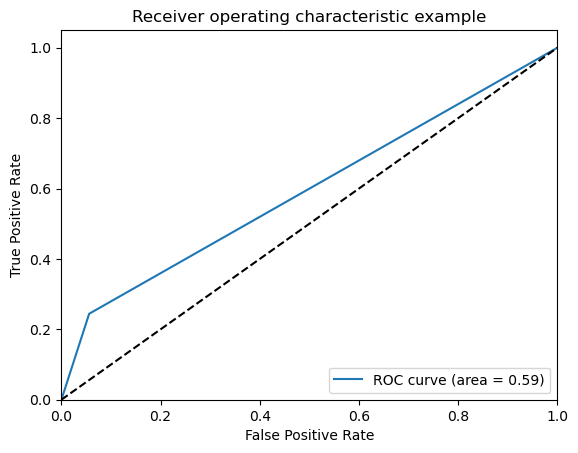

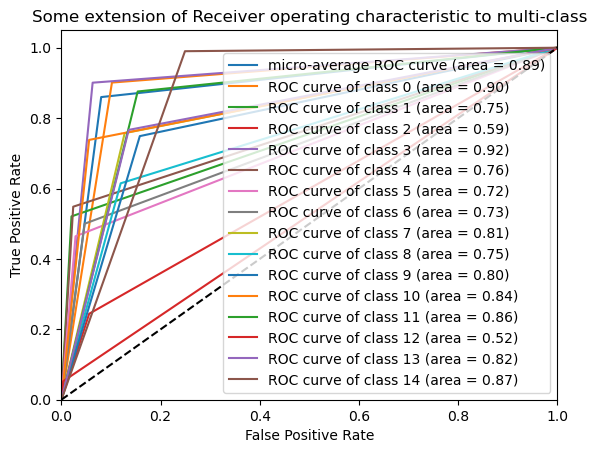

In [47]:
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(yseg_test).ravel(),  test_label_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(15):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()